In [ ]:
import os
import numpy as np
import json
import pickle
import zipfile
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    roc_curve,
    auc,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/CJPR/tfidf_embeddings.zip', 'r') as zip_ref:
    zip_ref.extractall('tfidf_embeddings')

In [ ]:
folder = '/content/tfidf_embeddings/tfidf_embeddings'
train_embed = np.load(os.path.join(folder, 'train_embed.npy'))
val_embed = np.load(os.path.join(folder, 'val_embed.npy'))
test_embed = np.load(os.path.join(folder, 'test_embed.npy'))
train_labels = np.load(os.path.join(folder, 'train_labels.npy'))
val_labels = np.load(os.path.join(folder, 'val_labels.npy'))
test_labels = np.load(os.path.join(folder, 'test_labels.npy'))

In [ ]:
# Initialize and train the logistic regression model
lr = LogisticRegression(max_iter=1500)

# Define parameter values and descriptions
param_values = [0.000001,0.00001,0.0001,0.001, 0.01, 0.1, 1, 10, 100]
param_descriptions = [
    "Very very micro regularization strength (C=0.000001)",
    "Very micro regularization strength (C=0.00001)",
    "Very very small regularization strength (C=0.0001)",
    "Very small regularization strength (C=0.001)",
    "Small regularization strength (C=0.01)",
    "Moderate regularization strength (C=0.1)",
    "Default regularization strength (C=1)",
    "Large regularization strength (C=10)",
    "Very large regularization strength (C=100)"
]

# Perform cross-validation to find the best parameters
param_grid = {'C': param_values}
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='f1')
grid_search.fit(train_embed, train_labels)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1500),
             param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                               100]},
             scoring='f1')

In [ ]:
best_params = grid_search.best_params_
best_lr_model = grid_search.best_estimator_

results = {
    'best_params': best_params
}
print(best_params)

{'C': 1e-06}


In [ ]:
for params, mean_test_accuracy, std_test_accuracy, description in zip(
    grid_search.cv_results_['params'],
    grid_search.cv_results_['mean_test_score'],
    grid_search.cv_results_['std_test_score'],
    param_descriptions
):
    params_str = f"C:{params['C']}"

    lr.set_params(**params)
    lr.fit(train_embed, train_labels)
    test_predictions = lr.predict(test_embed)
    fpr, tpr, _ = roc_curve(test_labels, lr.predict_proba(test_embed)[:, 1])
    roc_auc = auc(fpr, tpr)
    conf_matrix = confusion_matrix(test_labels, test_predictions)

    results[params_str] = {
        'description': description,
        'mean_test_accuracy': mean_test_accuracy,
        'std_test_accuracy': std_test_accuracy,
        'AUC': roc_auc,
        'accuracy': accuracy_score(test_labels, lr.predict(test_embed)),
        'f1_score': f1_score(test_labels, lr.predict(test_embed)),
        'recall': recall_score(test_labels, lr.predict(test_embed)),
        'precision': precision_score(test_labels, lr.predict(test_embed)),
        'confusion_matrix': conf_matrix.tolist()
    }

In [ ]:
test_predictions = best_lr_model.predict(test_embed)

conf_matrix = confusion_matrix(test_labels, test_predictions)

In [1]:
# Plot ROC curve and save AUC plot
fpr, tpr, _ = roc_curve(test_labels, best_lr_model.predict_proba(test_embed)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.savefig('/content/drive/MyDrive/CJPR/Classical/Logistic/TFIDF/best_roc_curve.png')  # Save the ROC curve plot as an image
plt.show()

# Save the results including AUC in the JSON file
results['AUC'] = roc_auc
results['TPR'] = list(tpr)
results['FPR'] = list(fpr)

NameError: ignored

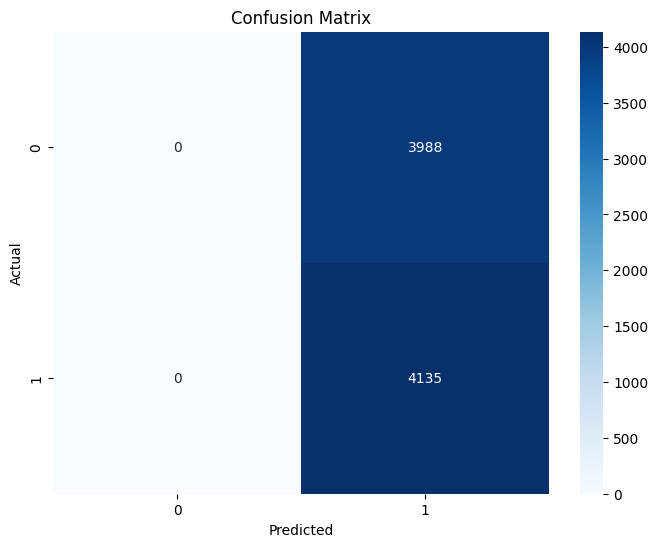

In [ ]:
# Draw and save the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/CJPR/Classical/Logistic/TFIDF/best_confusion_matrix.png')  # Save the confusion matrix plot as an image
plt.show()

In [ ]:
with open('/content/drive/MyDrive/CJPR/Classical/Logistic/TFIDF/logistic_regression_tfidf.json', 'w') as json_file:
    json.dump(results, json_file, indent=4)

In [ ]:
with open('/content/drive/MyDrive/CJPR/Classical/Logistic/TFIDF/logistic_regression_tfidf.pkl', 'wb') as model_file:
    pickle.dump(best_lr_model, model_file)